In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image

In [20]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


"""
1.  Define and build a PyTorch Dataset
"""
class CIFAR10(Dataset):
    def __init__(self, data_files, transform=None, target_transform=None):
        
        self.image_data = []
        self.image_labels = []
        for i in range(len(data_files)):
            data_dict = unpickle(data_files[i])
            # self.image_data += data_dict[b'data']
            if isinstance(self.image_data, list):
                self.image_data = data_dict[b'data']
            else:
                # Stack vertically (for 2D data)
                self.image_data = np.vstack((self.image_data, data_dict[b'data']))
            
            self.image_labels += data_dict[b'labels']

        self.transform = transform
        self.target_transform = target_transform

        # print(type(self.image_data[0]))

    def __len__(self):

        return len(self.image_data)

    def __getitem__(self, idx):
        
        image = self.image_data[idx]
        image = image.reshape(3,32,32)
        image = image.transpose(1,2,0)
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return (image, label)
    

def get_preprocess_transform(mode):

    transform = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return transform


def build_dataset(data_files, transform=None):

    dataset = CIFAR10(data_files, transform)

    return dataset



"""
2.  Build a PyTorch DataLoader
"""
def build_dataloader(dataset, loader_params):

    dataloader = DataLoader(dataset, batch_size=loader_params["batch_size"], shuffle=loader_params["shuffle"])
    # dataloader = DataLoader(dataset)

    return dataloader


"""
3. (a) Build a neural network class.
"""
# class BinaryActivation(nn.Module):
#     def __init__(self):
#         super(BinaryActivation, self).__init__()

#     def forward(self, x):
        
#         return torch.sign(x)
    

class FinetuneNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x
    

"""
3. (b)  Build a model
"""
def build_model(trained=False):

    net = FinetuneNet()

    return net


"""
4.  Build a PyTorch optimizer
"""
def build_optimizer(optim_type, model_params, hparams):

    if optim_type == "SGD":
        optimizer = torch.optim.SGD(params=model_params, lr=hparams)
    if optim_type == "Adam":
        optimizer = torch.optim.Adam(params=model_params, lr=hparams)

    return optimizer


"""
5. Training loop for model
"""
def train(train_dataloader, model, loss_fn, optimizer):

    loss_history = []
    accuracy_history = []

    for epoch in range(30):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch, (X, y) in enumerate(train_dataloader):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # losses.append(loss.detach().numpy())
            # losses.append(float(loss))
            total_loss += loss.item()
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == y).sum().item()
            total_predictions += y.size(0)

        epoch_loss = total_loss / len(train_dataloader)
        epoch_accuracy = correct_predictions / total_predictions
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')
    
    # Plot learning curve.
    # plt.plot(losses)
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting the accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy_history, label='Accuracy', color='orange')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


'''Run model'''
def run_model():

    new_model = build_model()
    train_dataset = build_dataset(['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5'], transform=get_preprocess_transform(train))
    train_params = {"batch_size": 64, "shuffle": True}
    train_dataloader = build_dataloader(train_dataset, train_params)   
    # train_dataloader = build_dataloader(train_dataset)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = build_optimizer("Adam", new_model.parameters(), hparams=0.01)
    train(train_dataloader, new_model, loss_fn, optimizer)

    return new_model
    


In [21]:
from torchvision import transforms

# it make take a little while to build the dataset 
example_dataset = build_dataset(["cifar-10-batches-py/data_batch_1"], transform=transforms.ToTensor())

Epoch 1, Loss: 2.314533574959201, Accuracy: 0.13668
Epoch 2, Loss: 2.095954865140988, Accuracy: 0.16794
Epoch 3, Loss: 1.8640649899497361, Accuracy: 0.27266
Epoch 4, Loss: 1.6684939765259432, Accuracy: 0.36876
Epoch 5, Loss: 1.5487118171304084, Accuracy: 0.42668
Epoch 6, Loss: 1.4751311174743926, Accuracy: 0.4587
Epoch 7, Loss: 1.4100200132945615, Accuracy: 0.48808
Epoch 8, Loss: 1.3770739599262052, Accuracy: 0.50414
Epoch 9, Loss: 1.3431669061293687, Accuracy: 0.5168
Epoch 10, Loss: 1.316917135130109, Accuracy: 0.52796
Epoch 11, Loss: 1.2919758276256454, Accuracy: 0.54044
Epoch 12, Loss: 1.274201213017754, Accuracy: 0.5479
Epoch 13, Loss: 1.2570361914994466, Accuracy: 0.55346
Epoch 14, Loss: 1.2347171224291673, Accuracy: 0.563
Epoch 15, Loss: 1.2207986476933559, Accuracy: 0.5693
Epoch 16, Loss: 1.2157904112430484, Accuracy: 0.57174
Epoch 17, Loss: 1.1943265292650598, Accuracy: 0.57862
Epoch 18, Loss: 1.185569247473841, Accuracy: 0.5819
Epoch 19, Loss: 1.1804299139610641, Accuracy: 0.5

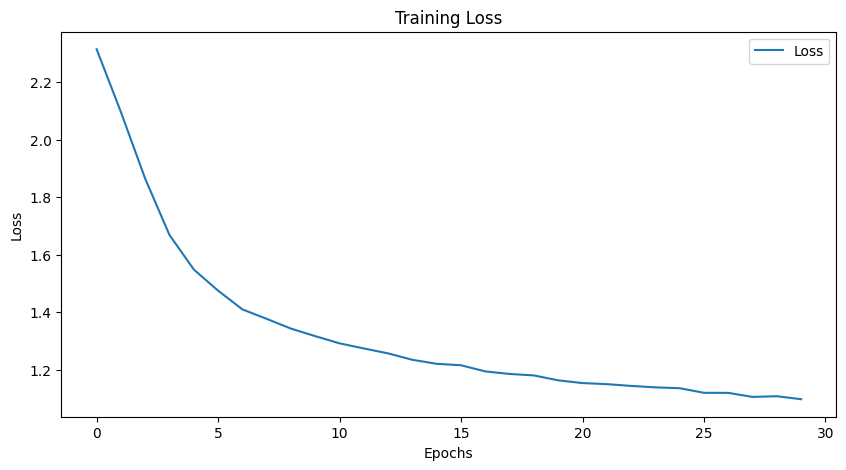

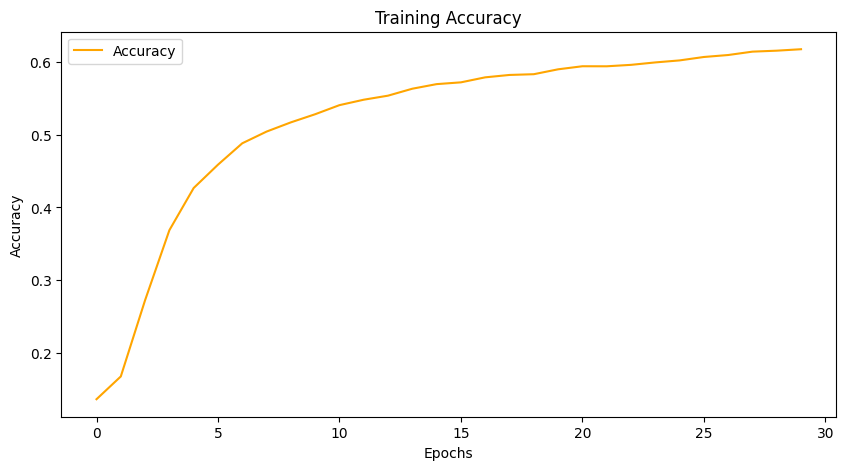

FinetuneNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [22]:
run_model()

